# New York
This will be an interesting one.  New York had an exponential increase in cases early in the year, followed by a steep drop-off and the cases have leveled out completely.  They haven't disappeared, but compared to the population and where they were, the situation definitely appears under control.  Let's go ahead and get started!   

In [1]:
import warnings
warnings.filterwarnings('ignore')
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import math
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.utils import Sequence
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from keras.callbacks import EarlyStopping
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as MSE
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
sns.set_style('darkgrid')
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import helper_functions
from helper_functions import acf_pacf
from helper_functions import decompose_time_series
from helper_functions import train_test
from helper_functions import create_dataset
from helper_functions import fit_model
from helper_functions import test_RMSE
from helper_functions import train_RMSE
# from helper_functions import preprocess_data
from helper_functions import plot_loss
from helper_functions import LSTM_prediction_plot
import pmdarima as pm

Using TensorFlow backend.


In [2]:
# Instantiate scaler
scaler = MinMaxScaler(feature_range=(0, 1))

def preprocess_data(df, column):
    '''
    Input DataFrame and column name
    
    Function will create a numpy array from the values and set them to float.
    The values will be reshaped and normalized.  Next the dataset will be 
    split into training, validation, and test sets.
    
    Returns: Training, Validation, and Test sets
    '''
    import warnings
    warnings.filterwarnings('ignore')
    import itertools
    import pandas as pd
    import numpy as np
    import statsmodels.api as sm
    import matplotlib.pyplot as plt
    from matplotlib.pylab import rcParams
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.metrics import mean_squared_error as MSE
    from statsmodels.tsa.seasonal import seasonal_decompose
    

    # Reset Index
    df = df.reset_index()
    
    # Create a series of only the values of the specified columns
    df = df[column].values
    
    # Reshape and convert to numpy array
    df = np.reshape(df, (-1, 1))
    
    # Normalize data
    df = scaler.fit_transform(df)
    
    # Define stopping points for Train and Validation Sets 
    train_stop = int(len(df) - 21)
    val_stop = int(train_stop + 7)
    
    # Define indices for train, val, and test
    train, val, test = df[0:train_stop,:], df[train_stop:val_stop,:], df[val_stop:,:]
    
    return train, val, test

# SARIMA

Time to load up the data.

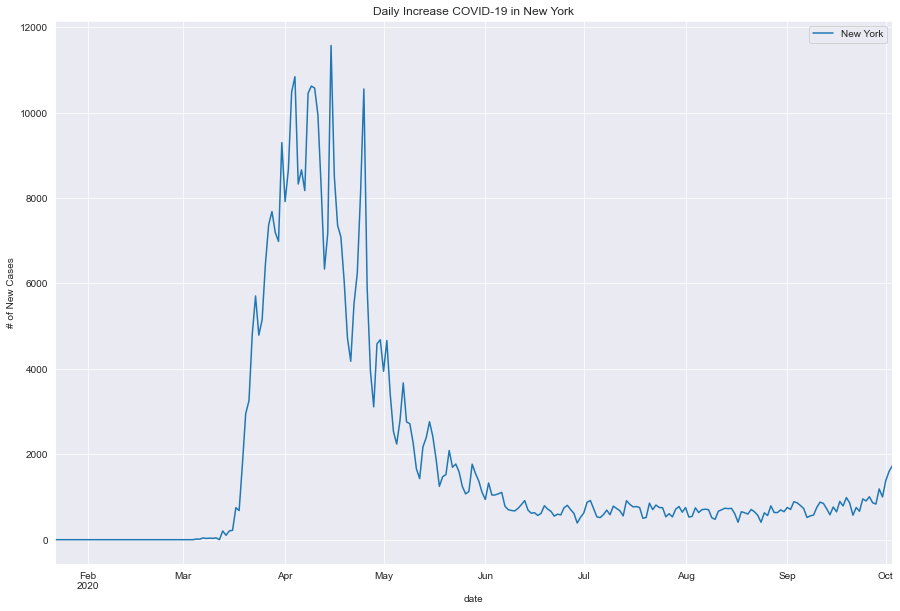

In [3]:
df = pd.read_csv('csv_files/national_positive_increase.csv')

# Rename 'Unnamed' to 'date'
df = df.rename(columns={'Unnamed: 0' : 'date'})

# Changing 'date' to date-time 
df['date'] = pd.to_datetime(df['date'])

# Set to index
df = df.set_index('date')

df = df.asfreq('D')

# New York
ny = df['NY_positiveIncrease']
ny.plot(figsize=(15, 10), label='New York')

plt.ylabel('# of New Cases')
plt.title('Daily Increase COVID-19 in New York')
plt.legend()
plt.show();


As we've done before, we're going to forgo the stationarity check since it's obviously non-stationary.



## ACF and PACF

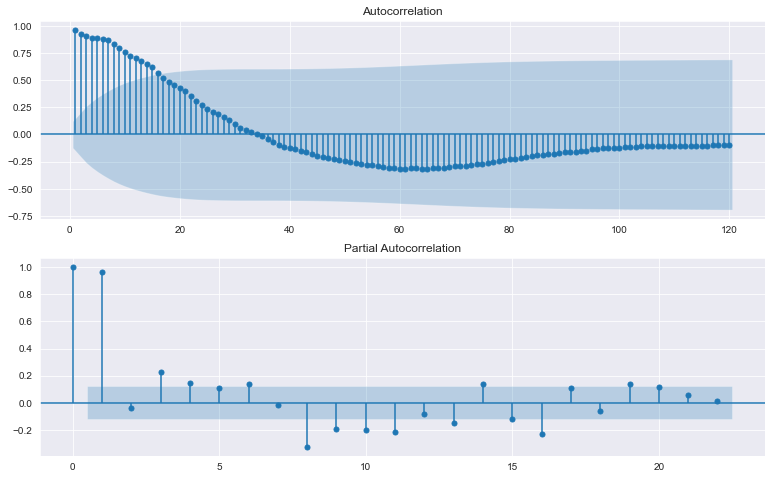

In [4]:
acf_pacf(ny)

New York proves to be pretty different from the other states.  The AR(`p`) term is 1 lag and the MA(`q`) term is up to 15 (our lowest values yet).

## Decomposition

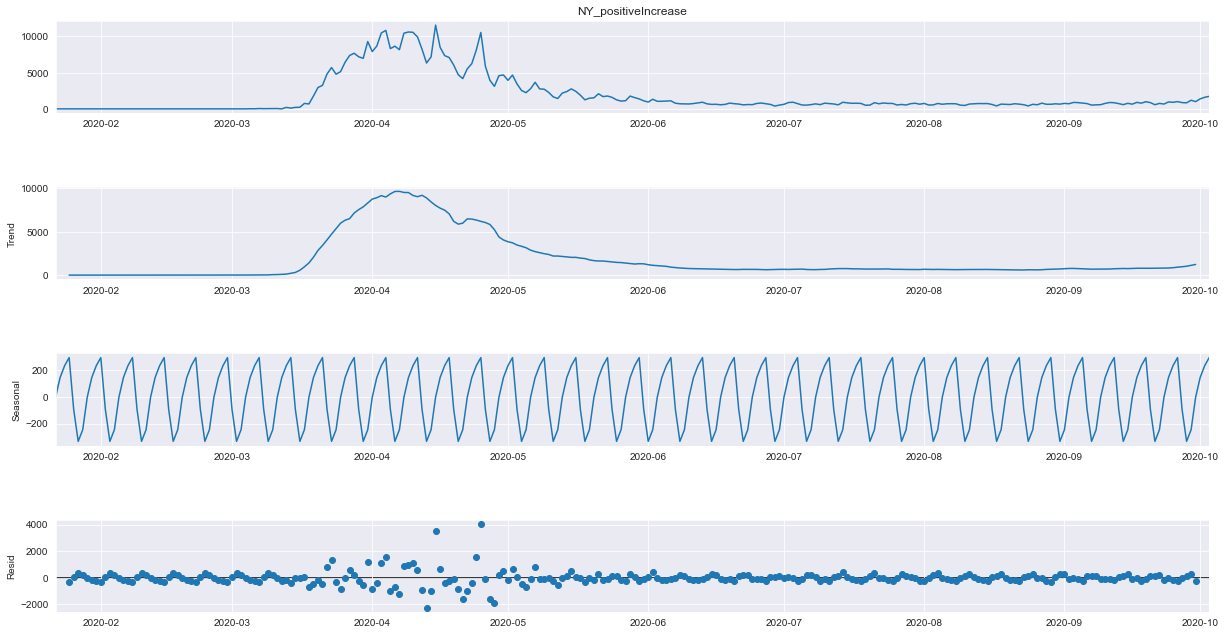

In [5]:
decompose_time_series(ny)

Again, there's an exponential trend in both directions again, seasonality is still weekly and the residuals are normally distributed, then they explode, and then they return to a pretty homoskedastic distribution.  The major difference is that the drastic increase in cases occurs during the spring as opposed to the summer.

## Auto ARIMA

In [6]:
ny_results = pm.auto_arima(ny, information_criterion='aic', m=7 ,start_d=0, 
                           max_d=2,
                        start_p=1,start_q=1, max_p=1, max_q=15,
                        stepwise=True,trace=True,error_action='ignore',
                           suppress_warnings=True)
ny_results

Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 0, 1, 7); AIC=4036.165, BIC=4057.412, Fit time=0.633 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 7); AIC=4070.518, BIC=4077.601, Fit time=0.012 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 7); AIC=4047.866, BIC=4062.032, Fit time=0.182 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 7); AIC=4053.757, BIC=4067.922, Fit time=0.181 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 1, 7); AIC=4045.224, BIC=4062.931, Fit time=0.508 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 0, 1, 7); AIC=4038.059, BIC=4062.848, Fit time=0.914 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 0, 0, 7); AIC=4037.521, BIC=4055.227, Fit time=0.460 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 0, 2, 7); AIC=4038.328, BIC=4063.117, Fit time=0.997 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 7); AIC=4068.324, BIC=4082.489, Fit time=0.223 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_o

ARIMA(callback=None, disp=0, maxiter=None, method=None, order=(1, 1, 4),
      out_of_sample_size=0, scoring='mse', scoring_args={},
      seasonal_order=(2, 0, 0, 7), solver='lbfgs', start_params=None,
      suppress_warnings=True, transparams=True, trend=None,
      with_intercept=True)

Our order is (1, 1, 4) and our seasonal order is (2, 0, 0, 7).  Very interesting how the Seasonal AR term has 2 lags when we saw that 

## Train-Test Split

In [7]:
ny_train, ny_test = train_test(ny)

## Model Fitting

                                     SARIMAX Results                                      
Dep. Variable:                NY_positiveIncrease   No. Observations:                  205
Model:             SARIMAX(1, 1, 4)x(2, 0, [], 7)   Log Likelihood               -1624.415
Date:                            Fri, 16 Oct 2020   AIC                           3264.831
Time:                                    09:41:51   BIC                           3291.375
Sample:                                01-22-2020   HQIC                          3275.568
                                     - 08-13-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8193      0.078     10.519      0.000       0.667       0.972
ma.L1         -0.9551      0.084   

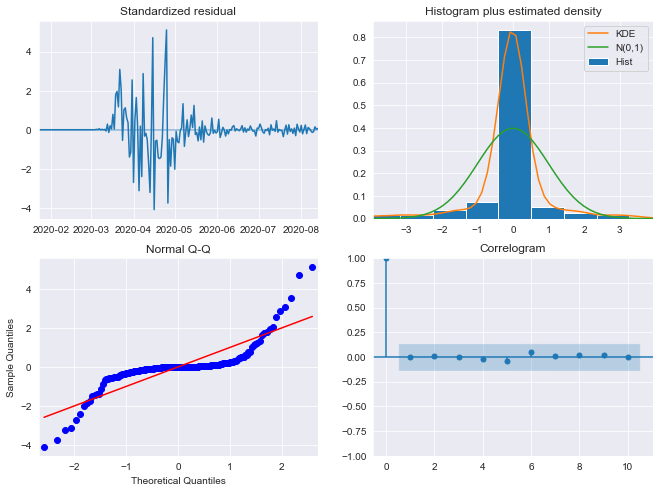

In [8]:
pdq = (1, 1, 4)
pdqs = (2, 0, 0, 7)
results = fit_model(ny_train, pdq=pdq, pdqs=pdqs)

## Results
Standardized Residuals: Explosion of variance, followed by a relatively homoskedastic distribution.

Normality: The histogram's Kernel Density Estimate is still showing a leptokurtic distribution of the Residuals. Strangely, this distribution seems to be g

QQ-Plot: The QQ-plot pretty much confirms that the residuals aren't following a normal distribution.  The residuals actually seem to deviate more from the mean than the others.  

This difference in normality is probably due to the fact that in previous states, our test sets happened to fall in the middle of the exponential trends.  Thus, no other training set had the full curve (trend).  I suspect that the other plots would look similar (or worse) had we had enough data to extend the training set so that it encompassed the entire summer trend of the time series.

Coefficients: MA(4) and AR.S(14) are statistically insignificant and should probably be removed via custom AR models.

### RMSE and Prediction Plots.

SARIMA model RMSE on train data: 116.43588


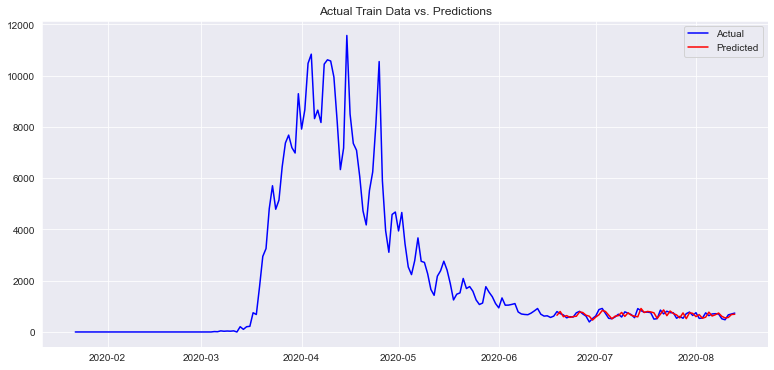

In [9]:
train_RMSE(ny_train, results, display = True)

SARIMA model RMSE on test data: 135.53368


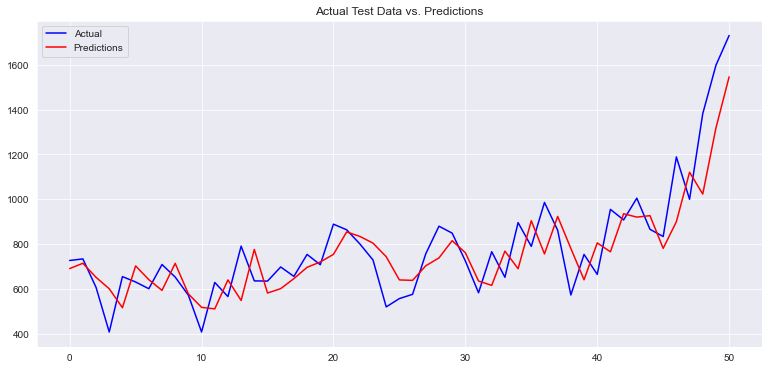

In [10]:
test_RMSE(ny_train, ny_test, pdq, pdqs, display=True)

* Train RMSE: 116.436
* Test RMSE: 135.533

Training Set: This is the first time that the Training set out performed the test set.  You can see how tightly the training predictions fit to the plot of actual values.  This is also the lowest RMSE we've seen in all of these states.  Again, this is probably due to the our training set including the entire trend of the plot and not just a portion of it.

Test Set: The test set performed a little worse than the training set, but only marginally.  It's predictions actually match up much better than previous SARIMA models, as well.  

Honestly, these results are fantastic and will be tough to beat. I assume that customizing the ARMA models to omit MA(4) and AR.S(14) would make it better, but only a little bit.

## Mean Prediction Forecast

Let's check out a forecast!

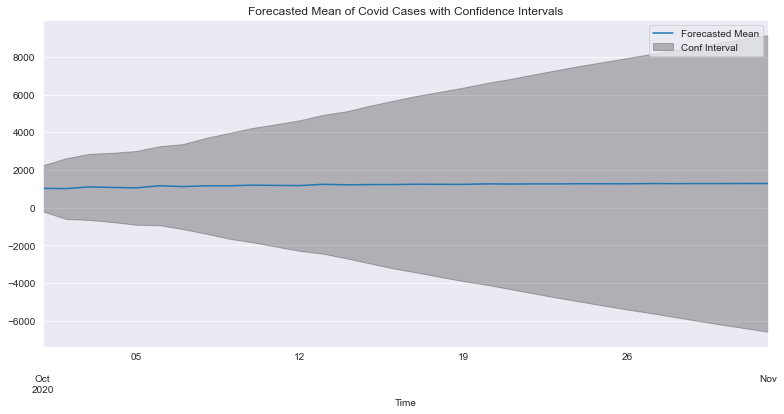

In [28]:
model = sm.tsa.statespace.SARIMAX(ny, order=pdq, seasonal_order=pdqs)
fit_model = model.fit()
output = fit_model.get_prediction(start='2020-10-01',end='2020-11-01', dynamic=True)
forecast_ci = output.conf_int()
fig, ax = plt.subplots(figsize=(13,6))
output.predicted_mean.plot(label='Forecasted Mean')
ax.fill_between(forecast_ci.index,forecast_ci.iloc[:, 0],forecast_ci.iloc[:, 1],
                        color='k', alpha=.25,label='Conf Interval')
plt.title('Forecasted Mean of Covid Cases with Confidence Intervals')
plt.xlabel('Time')
plt.legend(loc='best');
plt.show()

Interesting.  The mean of predictions is quite steady, almost perfectly straight.  What is more concerning is that this is the first model that forecasts a very subtle increase in the average daily cases.  Let's check this against reality!

Again, Using reports from the New York Times:

October 5th:
   * Forecast Prediction: A little over 1000
   * New York's Reported Actual: 937
   
October 12th: 
   * Forecast Prediction: Around 1200
   * New York's Reported Actual: 1,032

The forecast is high, but there is some validity to the notion that there could be an upcoming increase is cases.  On October 8th, New York reported 1,835 new cases (NYT). In fact, the only day so far that New York hadn't reported below 1000 new cases in a day was on October 5th (At the time of this writing, it is October 16, 2020).  

Will New York continue to see an increase in COVID-19 cases?  Depends on the citizens.  The governor is very quick to respond to any kind of increase with policy changes such as travel restrictions between states.  Out of state visitors must submit traveler health forms detailing where they are coming from, their final destination, where they are staying (including name of hotel and address), how long they are staying in New York, and if they visited other states or countries that are on the Health department's watch list (ny.gov).  Hotels are obligated to submit those forms to the state.  Even if they are not positive, they must quarantine themselves in their hotel rooms for 14 days.  Failure to comply or lying on your health form will result in charges and  fines of up to \$10,000 (NPR.org).  In cooperation with Bloomberg and Johns Hopkins University, they have created a dashboard for residents to stay updated on the current state of the pandemic.  Some of these steps seem quite Orwellian, but you can't deny the results.

Let's try out LSTMs.

# LSTM

## Splitting and Preprocessing

In [12]:
ny_train, ny_val, ny_test = preprocess_data(ny, 'NY_positiveIncrease')

print(f"Train has {len(ny_train)} values")
print(f"Validation has {len(ny_val)} values")
print(f"Test has {len(ny_test)} values")

Train has 235 values
Validation has 7 values
Test has 14 values


## Reshaping

In [13]:
look_back = 1

X_train, y_train = create_dataset(ny_train, look_back)
X_val, y_val = create_dataset(ny_val, look_back)
X_test, y_test = create_dataset(ny_test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

## Modeling

In [14]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, y_train, epochs=500, batch_size=70, 
                    validation_data=(X_val, y_val), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=100)], 
                    verbose=1, shuffle=False)

model.summary()

Train on 233 samples, validate on 5 samples
Epoch 1/500
233/233 [==============================] - 0s 2ms/step - loss: 0.0801 - val_loss: 0.0024
Epoch 2/500
233/233 [==============================] - 0s 51us/step - loss: 0.0741 - val_loss: 0.0014
Epoch 3/500
233/233 [==============================] - 0s 51us/step - loss: 0.0685 - val_loss: 6.6279e-04
Epoch 4/500
233/233 [==============================] - 0s 51us/step - loss: 0.0642 - val_loss: 2.4305e-04
Epoch 5/500
233/233 [==============================] - 0s 51us/step - loss: 0.0602 - val_loss: 9.3518e-05
Epoch 6/500
233/233 [==============================] - 0s 51us/step - loss: 0.0567 - val_loss: 1.7875e-04
Epoch 7/500
233/233 [==============================] - 0s 51us/step - loss: 0.0537 - val_loss: 4.5780e-04
Epoch 8/500
233/233 [==============================] - 0s 47us/step - loss: 0.0510 - val_loss: 8.8480e-04
Epoch 9/500
233/233 [==============================] - 0s 47us/step - loss: 0.0485 - val_loss: 0.0014
Epoch 10/500
23

233/233 [==============================] - 0s 56us/step - loss: 0.0046 - val_loss: 2.2727e-04
Epoch 80/500
233/233 [==============================] - 0s 47us/step - loss: 0.0048 - val_loss: 2.2100e-04
Epoch 81/500
233/233 [==============================] - 0s 47us/step - loss: 0.0050 - val_loss: 2.1180e-04
Epoch 82/500
233/233 [==============================] - 0s 47us/step - loss: 0.0046 - val_loss: 2.0454e-04
Epoch 83/500
233/233 [==============================] - ETA: 0s - loss: 0.002 - 0s 47us/step - loss: 0.0047 - val_loss: 2.0258e-04
Epoch 84/500
233/233 [==============================] - 0s 51us/step - loss: 0.0050 - val_loss: 2.0153e-04
Epoch 85/500
233/233 [==============================] - 0s 51us/step - loss: 0.0039 - val_loss: 2.0293e-04
Epoch 86/500
233/233 [==============================] - 0s 47us/step - loss: 0.0043 - val_loss: 2.0355e-04
Epoch 87/500
233/233 [==============================] - 0s 47us/step - loss: 0.0045 - val_loss: 2.0260e-04
Epoch 88/500
233/233 [====

## Results

### RMSE

In [15]:
from sklearn.metrics import mean_absolute_error as MAE

train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invert predictions to original scale for interpretation
train_predict = scaler.inverse_transform(train_predict)
y_train_rescaled = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test_rescaled = scaler.inverse_transform([y_test])

print('Train Mean Absolute Error:', MAE(y_train_rescaled[0], 
                                        train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(MSE(y_train_rescaled[0], 
                                               train_predict[:,0])))
print('Test Mean Absolute Error:', MAE(y_test_rescaled[0], 
                                       test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(MSE(y_test_rescaled[0], 
                                              test_predict[:,0])))

Train Mean Absolute Error: 372.79036021744236
Train Root Mean Squared Error: 741.7448938206549
Test Mean Absolute Error: 189.8622233072917
Test Root Mean Squared Error: 214.49718396147645


Now this is interesting.  This is the first time that the SARIMA models have out performed the LSTM model.  The training set RMSE is awful in comparison and the test RMSE, while not as bad as the training set, is still quite a bit higher than its SARIMA counterpart.  

Let's checkout the loss and see if we can pinpoint the problem.

### Model Loss

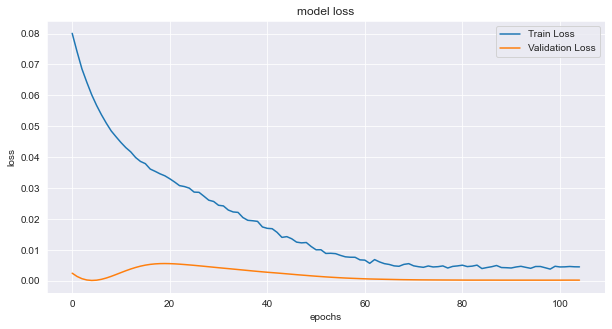

In [16]:
plot_loss(history)

It doesn't look like the model was overfit, or under fit.  Let's check the predictions and then see if we want to try decreasing and/or increasing patience.

### Predictions vs. Actuals

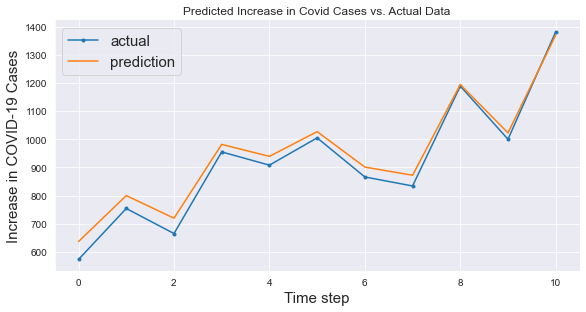

In [17]:
LSTM_prediction_plot(test_predict, y_test_rescaled)

Now this is interesting.  This is the first time the SARIMA model has out performed the This plot represents the dates between September 21st and October 1st. These correspond with Time steps 38 through 48 of the Test Prediction plot of the SARIMA model.  When you compare these two sections, this model is still a much better fit, despite having a larger RMSE.  

In spite of this better fit, my instincts tell me that it's better to pick the SARIMA model since it the RMSE is lower for in both sets.

Let's try to increase the number of epochs and see if that helps.

## Patience = 150

In [35]:
look_back = 1

X_train, y_train = create_dataset(ny_train, look_back)
X_val, y_val = create_dataset(ny_val, look_back)
X_test, y_test = create_dataset(ny_test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

p150_model = Sequential()
p150_model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
p150_model.add(Dropout(0.2))
p150_model.add(Dense(1))
p150_model.compile(loss='mean_squared_error', optimizer='adam')

p150_history = p150_model.fit(X_train, y_train, epochs=500, batch_size=70, 
                    validation_data=(X_val, y_val), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=150)], 
                    verbose=1, shuffle=False)

p150_model.summary()

Train on 233 samples, validate on 5 samples
Epoch 1/500
233/233 [==============================] - 1s 4ms/step - loss: 0.0867 - val_loss: 0.0027
Epoch 2/500
233/233 [==============================] - 0s 99us/step - loss: 0.0803 - val_loss: 0.0016
Epoch 3/500
233/233 [==============================] - 0s 86us/step - loss: 0.0753 - val_loss: 7.8587e-04
Epoch 4/500
233/233 [==============================] - 0s 69us/step - loss: 0.0700 - val_loss: 3.0791e-04
Epoch 5/500
233/233 [==============================] - 0s 73us/step - loss: 0.0666 - val_loss: 1.0383e-04
Epoch 6/500
233/233 [==============================] - 0s 69us/step - loss: 0.0627 - val_loss: 1.3741e-04
Epoch 7/500
233/233 [==============================] - 0s 69us/step - loss: 0.0591 - val_loss: 3.6816e-04
Epoch 8/500
233/233 [==============================] - 0s 64us/step - loss: 0.0569 - val_loss: 7.5430e-04
Epoch 9/500
233/233 [==============================] - 0s 69us/step - loss: 0.0543 - val_loss: 0.0013
Epoch 10/500
23

233/233 [==============================] - 0s 56us/step - loss: 0.0049 - val_loss: 1.9385e-04
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [36]:
train_predict = p150_model.predict(X_train)
test_predict = p150_model.predict(X_test)

# Invert predictions to original scale for interpretation
train_predict = scaler.inverse_transform(train_predict)
y_train_rescaled = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test_rescaled = scaler.inverse_transform([y_test])

print('Train Mean Absolute Error:', MAE(y_train_rescaled[0], 
                                        train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(MSE(y_train_rescaled[0], 
                                               train_predict[:,0])))
print('Test Mean Absolute Error:', MAE(y_test_rescaled[0], 
                                       test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(MSE(y_test_rescaled[0], 
                                              test_predict[:,0])))

Train Mean Absolute Error: 372.65997936592595
Train Root Mean Squared Error: 742.9788190622378
Test Mean Absolute Error: 189.8156382242839
Test Root Mean Squared Error: 214.77838674568136


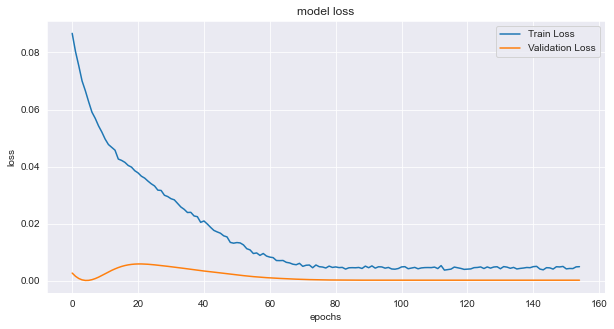

In [37]:
plot_loss(p150_history)

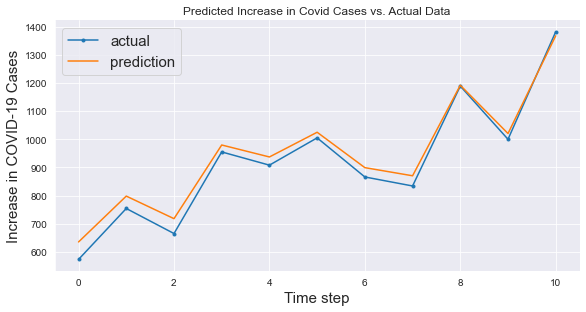

In [38]:
LSTM_prediction_plot(test_predict, y_test_rescaled)

Increasing `patience` to 150 resulted in virtually no change.

Let's try decreasing `patience`.

## Patience = 75

In [39]:
look_back = 1

X_train, y_train = create_dataset(ny_train, look_back)
X_val, y_val = create_dataset(ny_val, look_back)
X_test, y_test = create_dataset(ny_test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

p75_model = Sequential()
p75_model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
p75_model.add(Dropout(0.2))
p75_model.add(Dense(1))
p75_model.compile(loss='mean_squared_error', optimizer='adam')

p75_history = p75_model.fit(X_train, y_train, epochs=500, batch_size=70, 
                    validation_data=(X_val, y_val), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=75)], 
                    verbose=1, shuffle=False)

p75_model.summary()

Train on 233 samples, validate on 5 samples
Epoch 1/500
233/233 [==============================] - 1s 4ms/step - loss: 0.0858 - val_loss: 0.0027
Epoch 2/500
233/233 [==============================] - 0s 73us/step - loss: 0.0814 - val_loss: 0.0016
Epoch 3/500
233/233 [==============================] - 0s 64us/step - loss: 0.0746 - val_loss: 8.0989e-04
Epoch 4/500
233/233 [==============================] - 0s 69us/step - loss: 0.0709 - val_loss: 3.2043e-04
Epoch 5/500
233/233 [==============================] - 0s 69us/step - loss: 0.0662 - val_loss: 1.0625e-04
Epoch 6/500
233/233 [==============================] - 0s 69us/step - loss: 0.0620 - val_loss: 1.3509e-04
Epoch 7/500
233/233 [==============================] - 0s 73us/step - loss: 0.0587 - val_loss: 3.7025e-04
Epoch 8/500
233/233 [==============================] - 0s 73us/step - loss: 0.0561 - val_loss: 7.6731e-04
Epoch 9/500
233/233 [==============================] - 0s 86us/step - loss: 0.0533 - val_loss: 0.0013
Epoch 10/500
23

In [40]:
train_predict = p75_model.predict(X_train)
test_predict = p75_model.predict(X_test)

# Invert predictions to original scale for interpretation
train_predict = scaler.inverse_transform(train_predict)
y_train_rescaled = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test_rescaled = scaler.inverse_transform([y_test])

print('Train Mean Absolute Error:', MAE(y_train_rescaled[0], 
                                        train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(MSE(y_train_rescaled[0], 
                                               train_predict[:,0])))
print('Test Mean Absolute Error:', MAE(y_test_rescaled[0], 
                                       test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(MSE(y_test_rescaled[0], 
                                              test_predict[:,0])))

Train Mean Absolute Error: 420.1463699668262
Train Root Mean Squared Error: 764.7803742535469
Test Mean Absolute Error: 188.37527465820315
Test Root Mean Squared Error: 213.69360086158707


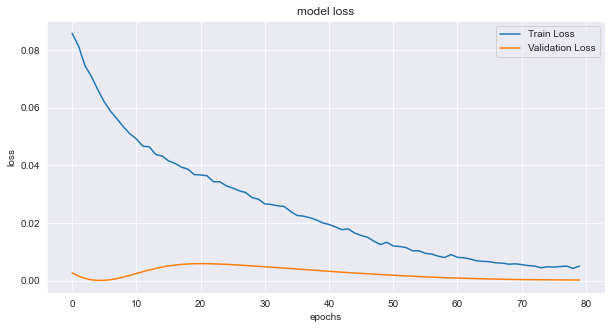

In [43]:
plot_loss(p75_history)

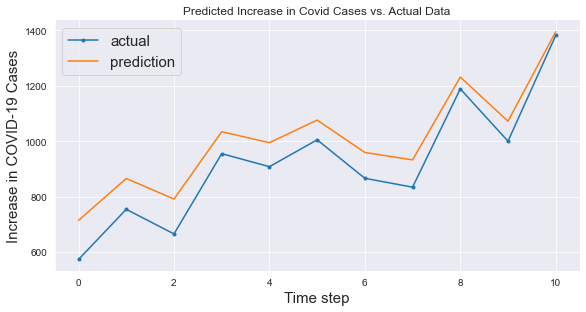

In [42]:
LSTM_prediction_plot(test_predict, y_test_rescaled)

Training RMSE increased and there was basically no change in the Test RMSE.  The predictions are actually beginning to underfit at this point.  Let's try one last model before we call it quits.

## Increase Overfitting

As noted before, we don't have a lot of data points.  Let's get rid of the DropOut layer and increase the number of neurons in an attempt to overfit our training data.

In [81]:
look_back = 1

X_train, y_train = create_dataset(ny_train, look_back)
X_val, y_val = create_dataset(ny_val, look_back)
X_test, y_test = create_dataset(ny_test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

model2 = Sequential()

model2.add(LSTM(200, input_shape=(X_train.shape[1], X_train.shape[2])))
model2.add(Dense(1))
model2.compile(loss='mean_squared_error', optimizer='adam')

history2 = model2.fit(X_train, y_train, epochs=500, batch_size=70, 
                    validation_data=(X_val, y_val), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=100)], 
                    verbose=1, shuffle=False)

model2.summary()

Train on 233 samples, validate on 5 samples
Epoch 1/500
233/233 [==============================] - 2s 8ms/step - loss: 0.0840 - val_loss: 0.0022
Epoch 2/500
233/233 [==============================] - 0s 116us/step - loss: 0.0762 - val_loss: 0.0010
Epoch 3/500
233/233 [==============================] - 0s 137us/step - loss: 0.0698 - val_loss: 3.2137e-04
Epoch 4/500
233/233 [==============================] - 0s 129us/step - loss: 0.0642 - val_loss: 9.1587e-05
Epoch 5/500
233/233 [==============================] - 0s 142us/step - loss: 0.0593 - val_loss: 2.6033e-04
Epoch 6/500
233/233 [==============================] - 0s 142us/step - loss: 0.0551 - val_loss: 7.5041e-04
Epoch 7/500
233/233 [==============================] - 0s 137us/step - loss: 0.0516 - val_loss: 0.0015
Epoch 8/500
233/233 [==============================] - 0s 146us/step - loss: 0.0486 - val_loss: 0.0023
Epoch 9/500
233/233 [==============================] - 0s 142us/step - loss: 0.0461 - val_loss: 0.0032
Epoch 10/500
23

Epoch 78/500
233/233 [==============================] - 0s 120us/step - loss: 0.0041 - val_loss: 1.9325e-04
Epoch 79/500
233/233 [==============================] - 0s 116us/step - loss: 0.0041 - val_loss: 1.9323e-04
Epoch 80/500
233/233 [==============================] - 0s 129us/step - loss: 0.0041 - val_loss: 1.9323e-04
Epoch 81/500
233/233 [==============================] - 0s 129us/step - loss: 0.0041 - val_loss: 1.9324e-04
Epoch 82/500
233/233 [==============================] - 0s 120us/step - loss: 0.0041 - val_loss: 1.9325e-04
Epoch 83/500
233/233 [==============================] - 0s 133us/step - loss: 0.0041 - val_loss: 1.9328e-04
Epoch 84/500
233/233 [==============================] - 0s 112us/step - loss: 0.0041 - val_loss: 1.9331e-04
Epoch 85/500
233/233 [==============================] - 0s 129us/step - loss: 0.0041 - val_loss: 1.9334e-04
Epoch 86/500
233/233 [==============================] - 0s 124us/step - loss: 0.0041 - val_loss: 1.9337e-04
Epoch 87/500
233/233 [======

In [82]:
train_predict = model2.predict(X_train)
test_predict = model2.predict(X_test)

# Invert predictions to original scale for interpretation
train_predict = scaler.inverse_transform(train_predict)
y_train_rescaled = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test_rescaled = scaler.inverse_transform([y_test])

print('Train Mean Absolute Error:', MAE(y_train_rescaled[0], 
                                        train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(MSE(y_train_rescaled[0], 
                                               train_predict[:,0])))
print('Test Mean Absolute Error:', MAE(y_test_rescaled[0], 
                                       test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(MSE(y_test_rescaled[0], 
                                              test_predict[:,0])))

Train Mean Absolute Error: 366.60565506439866
Train Root Mean Squared Error: 738.214678172187
Test Mean Absolute Error: 190.2669321695964
Test Root Mean Squared Error: 215.54547113810452


RMSE is virtually unchanged.

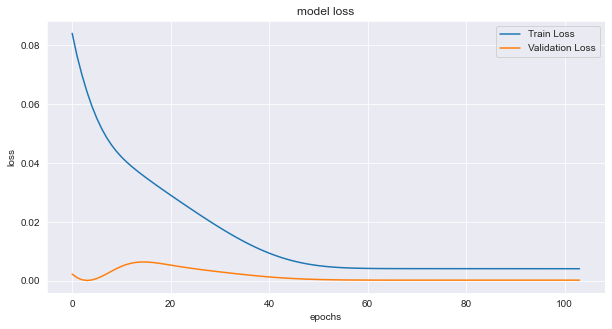

In [83]:
plot_loss(history2)

Only thing that changed here was that the train loss was much smoother.

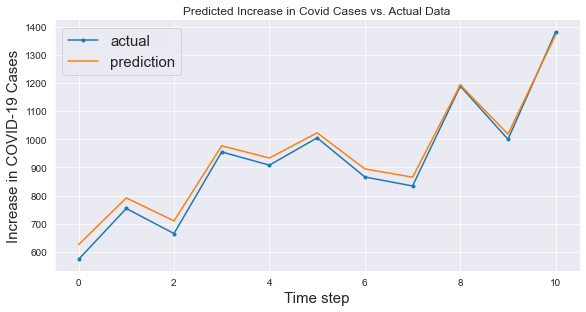

In [84]:
LSTM_prediction_plot(test_predict, y_test_rescaled)

Fit is marginally better than before.  You could stacked LSTMs but we're just getting diminishing returns at this point.

Again, even though we're getting better fit with the predictions, there is no guarantee that it will stay this way. Until I get more data to test this set on, I think the SARIMA model is the better model, in this instance.  